## 5- Baseline modeling experiment 3 - Autogluon TabularPredictor (AutoML)
* Using the open-source Autogluon AutoML library by AWS.
* Using baseline dataset.
* Autogluon will train an ensemble of models and find the best performing one.
    * Model will be __fit__ on the __train__ set.
    * The __validation__ set will be used to pick the best-performing model.
    * Final evaluation will be done on the __test__ set.

#### Stages
1. __Reading data__.
2. __Autogluon model training__.
3. __Model evaluation__.
4. __Saving predictor__.
5. __Feature importances on validation set__.

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold  # for splitting into train/val/test based on customer id while keeping fraud ratio the same for the three sets
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import (
    accuracy_score,
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score, 
    average_precision_score, 
    confusion_matrix, 
    classification_report
)
import autogluon
from autogluon.tabular import TabularPredictor
import warnings
warnings.filterwarnings("ignore")
import os

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
RANDOM_SEED = 420

### 1- Reading data

In [3]:
train_df = pd.read_csv("data/train_baseline.csv")
val_df = pd.read_csv("data/validation_baseline.csv")
test_df = pd.read_csv("data/test_baseline.csv")

In [4]:
train_df.shape

(476608, 30)

In [5]:
train_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.303248,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,0.018468,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.098661,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.186943,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,-0.017797,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0


In [6]:
val_df.shape

(60291, 30)

In [7]:
val_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.020728,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.168078,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.071645,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,-0.234106,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.622063,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [8]:
test_df.shape

(57744, 30)

In [9]:
test_df.head()

,step,amount,age_0,age_1,age_2,age_3,age_4,age_5,age_6,age_U,gender_E,gender_F,gender_M,gender_U,category_es_barsandrestaurants,category_es_contents,category_es_fashion,category_es_food,category_es_health,category_es_home,category_es_hotelservices,category_es_hyper,category_es_leisure,category_es_otherservices,category_es_sportsandtoys,category_es_tech,category_es_transportation,category_es_travel,category_es_wellnessandbeauty,fraud
0,-1.858796,-0.048201,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
1,-1.858796,-0.068440,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
2,-1.858796,-0.184287,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
3,-1.858796,0.027718,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0
4,-1.858796,0.457954,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0


### 2- Autogluon model training

In [10]:
save_path = 'models/baseline-autogluon-tabular-predictor' 

In [11]:
%%time

predictor = TabularPredictor(
    label="fraud",
    problem_type="binary",
    eval_metric="f1",
    path=save_path,
    sample_weight="balance_weight"
).fit(
    train_data=train_df,
    tuning_data=val_df,
    presets="medium_quality",
    verbosity=False,
    use_bag_holdout=True,
    num_cpus=os.cpu_count(),
    # Reproducbile results
    ag_args_fit={"random_seed": RANDOM_SEED}, # seed that every model will use
    ag_args_ensemble={
        "model_random_seed": RANDOM_SEED, # seed for per-fold child models
        "random_state": RANDOM_SEED  # seed for CV split in bagging
    }  
)

CPU times: user 2h 19min 4s, sys: 21.9 s, total: 2h 19min 26s
Wall time: 12min 42s


### 3- Model evaluation

In [12]:
def evaluate_model(model, X, y, name="model"):
    # # predictions
    # if hasattr(model, "predict_proba"):
    #     scores = model.predict_proba(X)[:, 1]
    # elif hasattr(model, "decision_function"):
    #     scores = model.decision_function(X)
    # else:
        # scores = model.predict(X)
    scores = model.predict(X)
        
    preds = (scores >= 0.5).astype(int)

    # metrics
    metrics = {
        "accuracy": accuracy_score(y, preds),
        "precision": precision_score(y, preds, zero_division=0),
        "recall": recall_score(y, preds, zero_division=0),
        "f1": f1_score(y, preds, zero_division=0),
        "roc_auc": roc_auc_score(y, scores) if len(np.unique(y)) > 1 else np.nan,
        "avg_precision": average_precision_score(y, scores),
        "classification_report": classification_report(y, preds, digits=3)
    }
    print(f"\n{name} — metrics\n")
    for k in ["accuracy", "precision", "recall", "f1", "roc_auc", "avg_precision"]:
        v = metrics[k]
        print(f"{k:>14}: {v:.4f}" if v==v else f"{k:>14}: nan")
    print("\nClassification report:\n", metrics["classification_report"])
    
    # confusion matrix
    cm = confusion_matrix(y, preds, labels=[0, 1])
    fig, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(
        cm,
        fmt="d",
        cbar=True,
        annot=True,
        xticklabels=("Non_Fraudulent", "Fraudulent"),
        yticklabels=("Non_Fraudulent", "Fraudulent"),
        ax=ax,
        cmap="cividis"
    )
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")
    ax.set_title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()
    return metrics

#### 3.1- Evaluation on validation set

In [13]:
%%time

predictor.evaluate(val_df)

CPU times: user 4.93 s, sys: 244 ms, total: 5.17 s
Wall time: 900 ms


{'f1': 0.7502799552071668,
 'accuracy': 0.9963012721633411,
 'balanced_accuracy': np.float64(0.8318896666499407),
 'mcc': 0.7548261088658379,
 'roc_auc': np.float64(0.9937185075802166),
 'precision': 0.8611825192802056,
 'recall': 0.6646825396825397}

In [14]:
leaderboard_val = predictor.leaderboard(val_df).sort_values("score_val", ascending=False)

In [15]:
leaderboard_val.shape

(12, 13)

In [16]:
leaderboard_val.head(50)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,0.750280,0.750280,f1,0.870956,0.562025,449.756770,0.009402,0.005831,1.136875,2,True,12
1,NeuralNetTorch,0.740991,0.740991,f1,0.083523,0.080131,251.043254,0.083523,0.080131,251.043254,1,True,10
2,ExtraTreesEntr,0.733634,0.733634,f1,0.264913,0.111784,18.339977,0.264913,0.111784,18.339977,1,True,7
3,RandomForestEntr,0.731597,0.731597,f1,0.178248,0.098904,19.772165,0.178248,0.098904,19.772165,1,True,4
4,ExtraTreesGini,0.721088,0.721088,f1,0.275774,0.118373,18.514847,0.275774,0.118373,18.514847,1,True,6
5,RandomForestGini,0.719637,0.719637,f1,0.162068,0.100106,19.517568,0.162068,0.100106,19.517568,1,True,3
6,NeuralNetFastAI,0.710723,0.710723,f1,0.310913,0.225815,158.193725,0.310913,0.225815,158.193725,1,True,8
7,LightGBMLarge,0.650672,0.650672,f1,3.774425,3.848711,156.056515,3.774425,3.848711,156.056515,1,True,11
8,LightGBM,0.596105,0.596105,f1,3.747967,3.743580,104.010241,3.747967,3.743580,104.010241,1,True,2
9,LightGBMXT,0.191117,0.191117,f1,0.002791,0.006810,0.549006,0.002791,0.006810,0.549006,1,True,1



Baseline Experiment - Autogluon Validation Set — metrics

      accuracy: 0.9963
     precision: 0.8612
        recall: 0.6647
            f1: 0.7503
       roc_auc: 0.8319
 avg_precision: 0.5752

Classification report:
               precision    recall  f1-score   support

           0      0.997     0.999     0.998     59787
           1      0.861     0.665     0.750       504

    accuracy                          0.996     60291
   macro avg      0.929     0.832     0.874     60291
weighted avg      0.996     0.996     0.996     60291



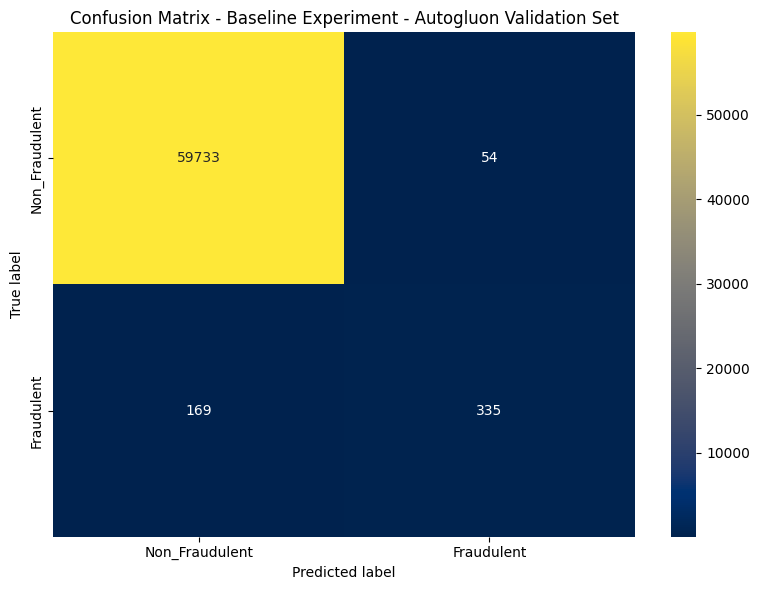

CPU times: user 5.01 s, sys: 156 ms, total: 5.17 s
Wall time: 950 ms


In [17]:
%%time

target_column = "fraud"
feature_columns = [column for column in train_df.columns if column != target_column]

X_val = val_df[feature_columns].copy()
y_val = val_df[target_column].astype(int).copy()

metrics = evaluate_model(
    model=predictor,
    X=X_val,
    y=y_val,
    name="Baseline Experiment - Autogluon Validation Set"
)

#### 3.2- Evaluation on test set

In [18]:
%%time

predictor.evaluate(test_df)

CPU times: user 4.94 s, sys: 209 ms, total: 5.15 s
Wall time: 855 ms


{'f1': 0.7526170798898072,
 'accuracy': 0.9922243003602106,
 'balanced_accuracy': np.float64(0.8197742363016195),
 'mcc': 0.7608517415055338,
 'roc_auc': np.float64(0.9927634879160355),
 'precision': 0.9118825100133512,
 'recall': 0.6407129455909943}

In [19]:
leaderboard_test = predictor.leaderboard(test_df).sort_values("score_test", ascending=False)

In [20]:
leaderboard_test.shape

(12, 13)

In [21]:
leaderboard_test.head(50)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,NeuralNetTorch,0.760965,0.740991,f1,0.081008,0.080131,251.043254,0.081008,0.080131,251.043254,1,True,10
1,WeightedEnsemble_L2,0.752617,0.750280,f1,0.851666,0.562025,449.756770,0.009446,0.005831,1.136875,2,True,12
2,RandomForestEntr,0.741228,0.731597,f1,0.179444,0.098904,19.772165,0.179444,0.098904,19.772165,1,True,4
3,RandomForestGini,0.734694,0.719637,f1,0.166580,0.100106,19.517568,0.166580,0.100106,19.517568,1,True,3
4,ExtraTreesEntr,0.728075,0.733634,f1,0.289229,0.111784,18.339977,0.289229,0.111784,18.339977,1,True,7
5,ExtraTreesGini,0.724574,0.721088,f1,0.285331,0.118373,18.514847,0.285331,0.118373,18.514847,1,True,6
6,LightGBMLarge,0.715336,0.650672,f1,3.547421,3.848711,156.056515,3.547421,3.848711,156.056515,1,True,11
7,LightGBM,0.701803,0.596105,f1,3.654962,3.743580,104.010241,3.654962,3.743580,104.010241,1,True,2
8,NeuralNetFastAI,0.685129,0.710723,f1,0.268938,0.225815,158.193725,0.268938,0.225815,158.193725,1,True,8
9,LightGBMXT,0.331130,0.191117,f1,0.002600,0.006810,0.549006,0.002600,0.006810,0.549006,1,True,1



Baseline Experiment - Autogluon Test Set — metrics

      accuracy: 0.9922
     precision: 0.9119
        recall: 0.6407
            f1: 0.7526
       roc_auc: 0.8198
 avg_precision: 0.5909

Classification report:
               precision    recall  f1-score   support

           0      0.993     0.999     0.996     56678
           1      0.912     0.641     0.753      1066

    accuracy                          0.992     57744
   macro avg      0.953     0.820     0.874     57744
weighted avg      0.992     0.992     0.992     57744



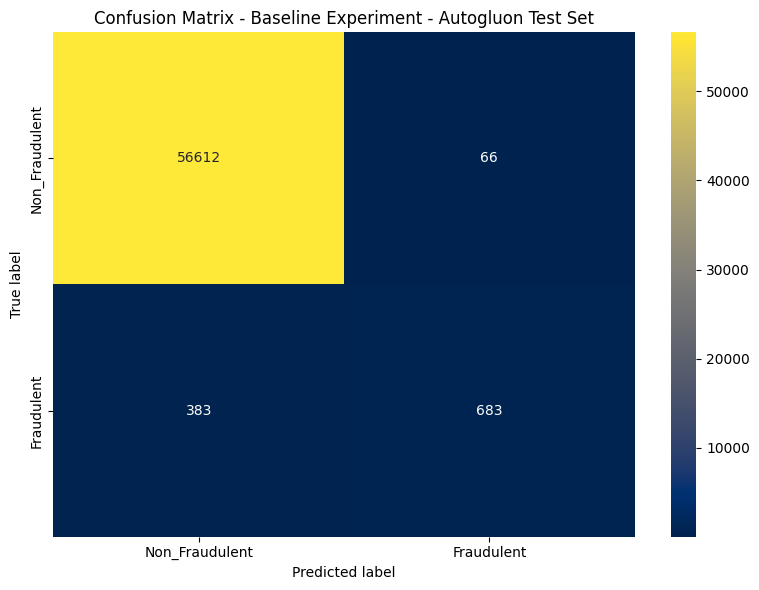

CPU times: user 4.9 s, sys: 160 ms, total: 5.06 s
Wall time: 906 ms


In [22]:
%%time

target_column = "fraud"
feature_columns = [column for column in train_df.columns if column != target_column]

X_test = test_df[feature_columns].copy()
y_test = test_df[target_column].astype(int).copy()

metrics = evaluate_model(
    model=predictor,
    X=X_test,
    y=y_test,
    name="Baseline Experiment - Autogluon Test Set"
)

### 4- Saving predictor

In [23]:
%%time

predictor.save()

CPU times: user 168 ms, sys: 2 μs, total: 168 ms
Wall time: 168 ms


### 5- Feature importances on validation set

In [1]:
import pandas as pd
from autogluon.tabular import TabularPredictor

/home/tamer/anaconda3/envs/fraud-detection-case-study/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
val_df = pd.read_csv("data/validation_baseline.csv")
save_path = "models/baseline-autogluon-tabular-predictor"
predictor = TabularPredictor.load(save_path, verbosity=2)

In [5]:
%%time

# Permutation importance
feature_importances = predictor.feature_importance(
    data=val_df,
    subsample_size=None, # set None to use all rows
    num_shuffle_sets=5 # tighter confidence bands (more compute)
).sort_values("importance", ascending=False)

These features in provided data are not utilized by the predictor and will be ignored: ['gender_E']
Computing feature importance via permutation shuffling for 28 features using 60291 rows with 5 shuffle sets...
	102.16s	= Expected runtime (20.43s per shuffle set)
	83.38s	= Actual runtime (Completed 5 of 5 shuffle sets)


CPU times: user 12min 31s, sys: 3.48 s, total: 12min 34s
Wall time: 1min 23s


In [6]:
feature_importances

,importance,stddev,p_value,n,p99_high,p99_low
amount,0.676207,0.005011,3.617343e-10,5,0.686524,0.665890
category_es_transportation,0.340470,0.012214,1.984227e-07,5,0.365619,0.315321
category_es_health,0.088851,0.001136,3.206046e-09,5,0.091190,0.086512
gender_M,0.027810,0.012129,3.426151e-03,5,0.052783,0.002837
gender_F,0.027375,0.006408,3.353425e-04,5,0.040569,0.014182
step,0.025638,0.008171,1.086811e-03,5,0.042463,0.008813
age_3,0.022595,0.004163,1.322569e-04,5,0.031167,0.014023
category_es_tech,0.017732,0.000619,1.775216e-07,5,0.019006,0.016458
age_2,0.016165,0.007076,3.471999e-03,5,0.030736,0.001595
age_4,0.012480,0.004604,1.870109e-03,5,0.021959,0.003000
